This is a script for computing the optimal values of the NST periods (in the sense that they minimize the overlap with the true template).
This adresses the case when the data has very few signal cycles. If the data contains many signal cycles the overlap is small anyways.
Here we assume dense sampling with no gaps. If you have a specialized problem with significant gaps in the data and few signal cycles, you might want to recompute the optimal periods by modifying this code slightly (or contact me).

We will here fix the null template and find the true template which matches it best. Without loss of generality we will take period = 1, phase = 0.

In [9]:
import jax
import jax.numpy as jnp
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from LombScargle import periodogram
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('../img/style.mplstyle')



def nst(y, mask):
    """ Null Signal Template
        y: data for the NST periods"""
    
    def get_periods(freq, total_time):
        """Convert the y to the periods of cycles.
            cycles is a float = freq * total time"""
        cycles= freq * total_time
        cycles_frac, _cycles_integer = jnp.modf(cycles)
        cycles_integer = _cycles_integer.astype(int)

        weights = (jnp.arange(1, len(y)+1) <= cycles).astype(float)  
        weights = weights.at[cycles_integer].set(cycles_frac)
        return total_time * y / jnp.sum(y * weights)


    def temp(_t, freq):
        t = _t - jnp.min(_t)
        periods = get_periods(freq, jnp.max(t)) 
        grid = jnp.cumsum(periods)
        grid_paddled = jnp.insert(grid, 0, 0.)
        which_period = jnp.searchsorted(grid, t)
        x = (t - grid_paddled[which_period]) / periods[which_period]
        return jnp.sin(2 * jnp.pi * x), jnp.cos(2 * jnp.pi * x)
    
    def get_mask(_t, freq):
        t = _t - jnp.min(_t)
        periods = get_periods(freq, jnp.max(t)) 
        grid = jnp.cumsum(periods)
        which_period = jnp.searchsorted(grid, t)
        return mask[which_period]
    
    return temp, get_mask


def uniform(key, spread, num_reps, cycles):
    num = (int)(cycles + 1)
    return jax.random.uniform(key, shape= (num_reps, num), minval= 1., maxval= spread)  
    
    
def overlap(y, mask_y):
    """period = 1, phase = 0, without loss of generality"""
    
    temp_func, get_mask = nst(y, mask_y)
    cycles= mask_y.shape[0]
    
    _time = jnp.linspace(0, cycles, (int)(cycles * 20))
    mask = get_mask(_time, 1.)
    time = _time[mask]
    data = temp_func(time, 1.)[0] # data = modified template
    
    # frequency range
    c= jnp.log10(10.)
    freq = jnp.logspace(-c, c, 1000)
    
    # scan with the true template
    score_modified = jnp.max(jax.vmap(periodogram.lomb_scargle(time, data, floating_mean= False))(freq)[0])

    score_og = periodogram.lomb_scargle(time, data, floating_mean= False, temp_func= temp_func)(1.)[0]
    
    return score_modified / score_og

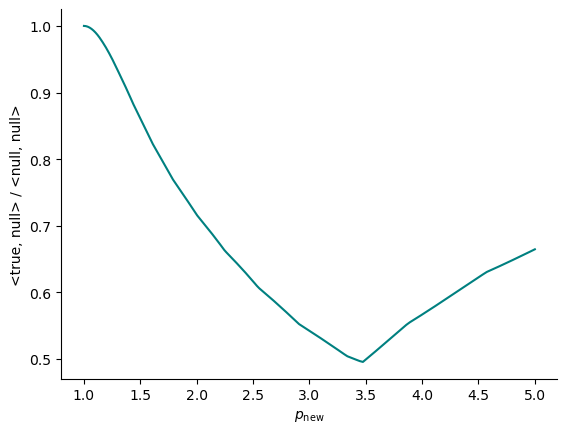

(200, 3)


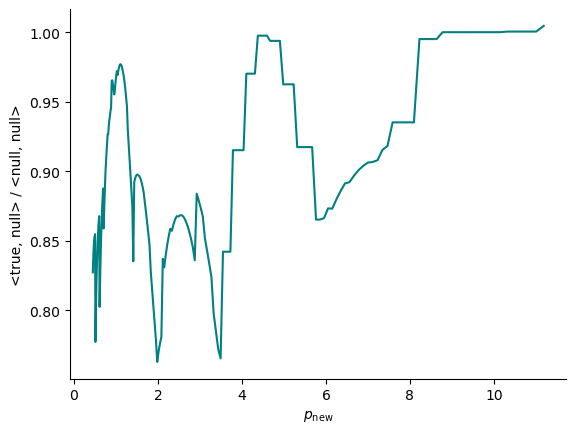

(200, 4)


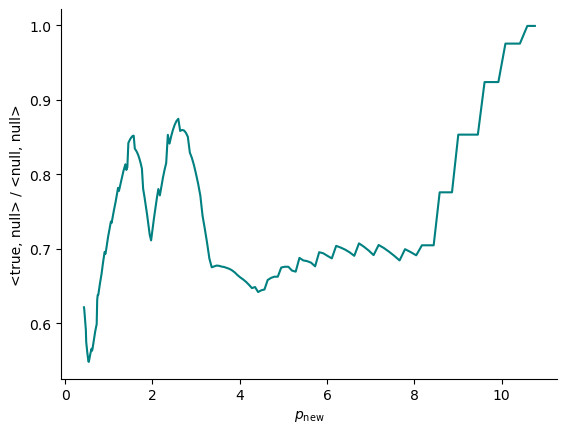

(200, 5)


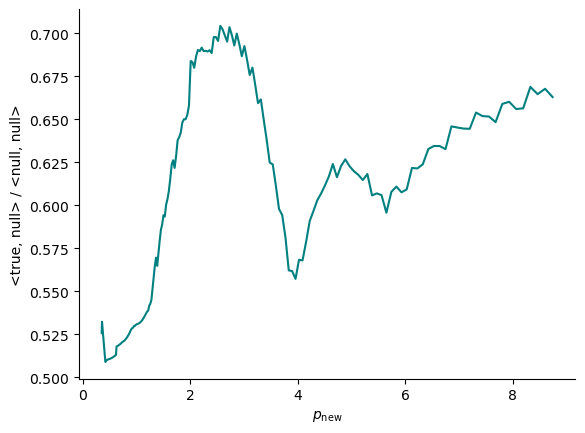

(200, 6)


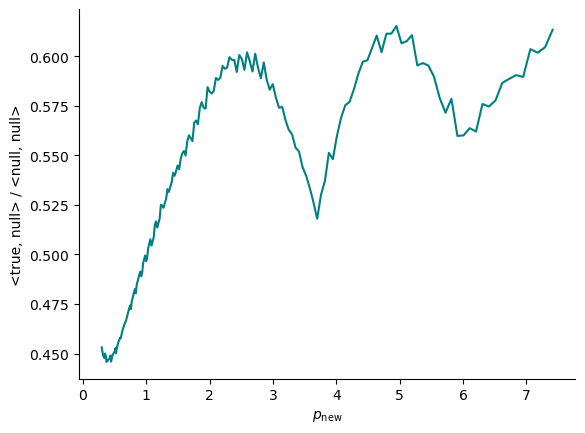

(200, 7)


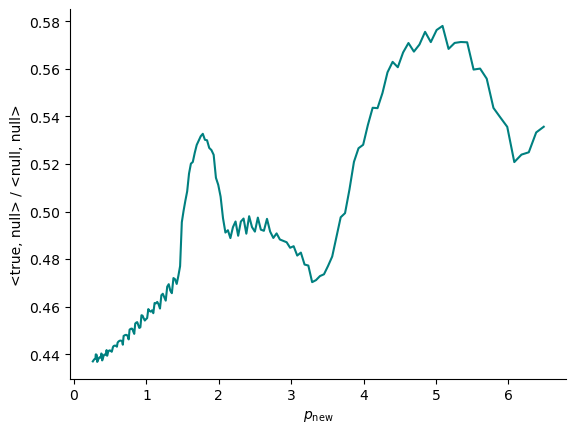

In [10]:
plott = True
num = 200

def iteration(y_old, borders):
    y_new = np.logspace(*np.log10(borders), num) * np.average(y_old)
    
    y = np.vstack([np.outer(y_old, np.ones(num)), y_new]).T
    Mask_y = ~np.eye(len(y_old) + 1).astype(bool) # mask for dropping out one cycle (rows are different options for which cycle to drop)

    if len(y_old) == 1:
        scores = np.array([overlap(jnp.array(yy), jnp.ones(2).astype(bool)) for yy in y])
    else:
        scores= np.array([[overlap(jnp.array(yy), jnp.array(mask_y)) for mask_y in Mask_y] for yy in y])
        print(scores.shape)
        scores = np.max(scores, axis= 1)
        
    if plott:
        plt.plot(y_new, scores)
        plt.xlabel(r'$p_{\mathrm{new}}$')
        plt.ylabel('<true, null> / <null, null>')
        plt.show()
    
    ibest = np.argmin(scores)
    
    y_old.append(y_new[ibest])
        
    return y_old, scores[ibest]

y = [1., ]
scores = []
borders = [[1., 5., ], ] + [[0.2, 5.] for i in range(5)]

for border in borders:    
    
    y, score = iteration(y, border)
    scores.append(score)
    

In [12]:
print(y)
print((np.array(y)/np.average(y)).tolist())

[1.0, 3.4746531667419385, 1.9817241487934127, 0.5398152907752701, 0.4179312321235251, 0.37193527144622873, 0.32027213572000546]
[0.8635225711753599, 3.0004414364876055, 1.7112635323263894, 0.4661426878500358, 0.3608930521377926, 0.32117450191005287, 0.27656221811276294]


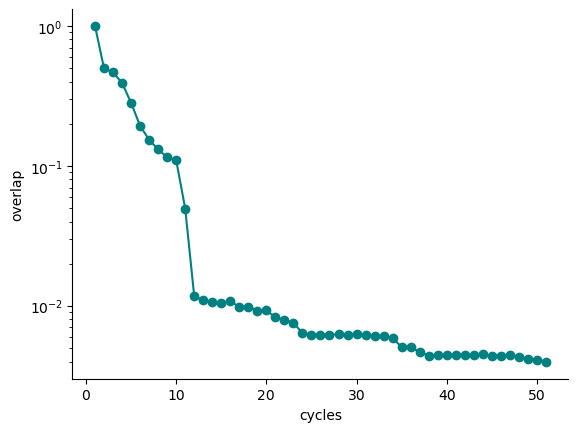

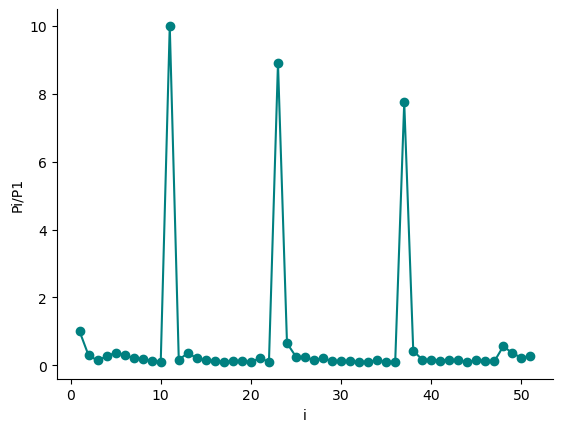

In [5]:
cycles = np.arange(1, len(scores) + 1)
plt.plot(cycles, scores, 'o-')
plt.xlabel('cycles')
plt.ylabel('overlap')
plt.yscale('log')
plt.show()

plt.plot(cycles, y, 'o-')
plt.xlabel('i')
plt.ylabel('Pi/P1')
plt.show()


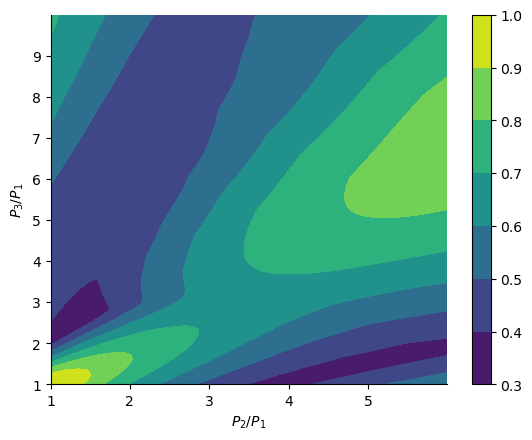

In [84]:
num = 200
p2 = jnp.logspace(0., jnp.log10(6.), num)
p3 = jnp.logspace(0., jnp.log10(10.), num)
P2, P3 = jnp.meshgrid(p2, p3)
P1 = jnp.ones(P2.shape)
y = jnp.array([P1, P2, P3])
scores = jax.vmap(jax.vmap(mainn, (1, None)), (1, None))(y, 3.)
plt.contourf(np.array(P2), np.array(P3), np.array(scores))
plt.xlabel(r'$P_2 / P_1$')
plt.ylabel(r'$P_3 / P_1$')
plt.colorbar()
plt.show()

In [87]:
z1 = p2[np.argmin(np.min(scores, axis = 0))]
z2 = p3[np.argmin(np.min(scores, axis = 1))]
print(1./z1, 1./z2, z1/z2)

0.7912833 0.41026583 0.5184816


In [79]:
i = np.argmin(np.min(scores, axis = 1))
j = np.argmin(np.min(scores, axis = 0))
print(i, j, p2[i], p3[j])

19 13 1.4103996 1.8420699
